<a href="https://colab.research.google.com/github/Noosonic/PMU-B-PersonalAI/blob/main/Copy_of_PMUB_Personal_AI_Image_classification_EfficientNetB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs Dogs : Image Classification using EfficienNet

## Data Description

**The training archive contains 25,000 images of dogs and cats.**


## Install

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00


## Loading Libraries

> TensorFlow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras import callbacks
from keras.callbacks import Callback
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [5]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

## Data Extraction

In [6]:
data_dir = '/content/sample_data'
%cd '/content/sample_data'
!pwd

/content/sample_data
/content/sample_data


In [7]:
path_to_downloaded_file = tf.keras.utils.get_file(
    origin=dataset_url,
    extract=True,
)

824887076/824887076 [==============================] - 11s 0us/step


In [8]:
path_to_downloaded_file

'/root/.keras/datasets/kagglecatsanddogs_5340.zip'

In [9]:
import zipfile

with zipfile.ZipFile(path_to_downloaded_file, 'r') as zipp:
    zipp.extractall(data_dir)

In [10]:
import glob

Cat_count = len(list(glob.glob(f'{data_dir}/PetImages/Cat/*.jpg')))
print('Cat: ', Cat_count)

Dog_count = len(list(glob.glob(f'{data_dir}/PetImages/Dog/*.jpg')))
print('Dog: ', Dog_count)

Cat:  12500
Dog:  12500


### Loading Images in a Dataframe

In [11]:
df_dada = pd.DataFrame(columns=['filename', 'label'])
list_dir = ["Cat", "Dog"]
for label in list_dir:
    filenames = list(glob.glob(f'{data_dir}/PetImages/{label}/*.jpg'))
    #labels = [x.split("/")[3] for x in filenames]
    data = pd.DataFrame({"filename": filenames, "label": label})
    data = data.iloc[:1250,]
    df_dada = df_dada.append(data)

print(df_dada.shape)
df_dada.head()

(2500, 2)


<ipython-input-11-151eb01fbb23>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dada = df_dada.append(data)
<ipython-input-11-151eb01fbb23>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dada = df_dada.append(data)


,filename,label
0,/content/sample_data/PetImages/Cat/8879.jpg,Cat
1,/content/sample_data/PetImages/Cat/8157.jpg,Cat
2,/content/sample_data/PetImages/Cat/4192.jpg,Cat
3,/content/sample_data/PetImages/Cat/6075.jpg,Cat
4,/content/sample_data/PetImages/Cat/3451.jpg,Cat


## Data Exploration

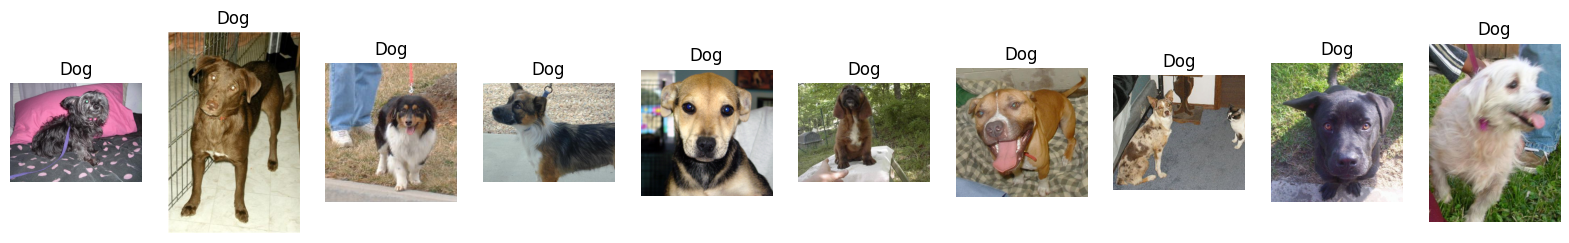

In [12]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Dog/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

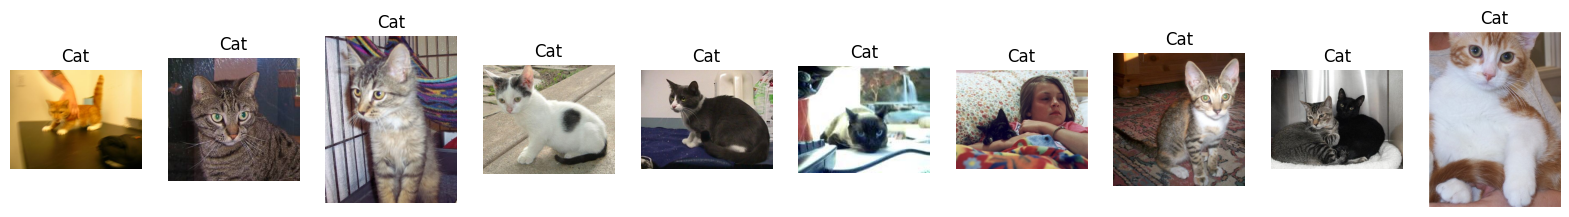

In [13]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Cat/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

### Train Test Split

In [14]:
# train test split using dataframe

labels = df_dada['label']

X_train, X_temp = train_test_split(df_dada, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (2000, 2)
The shape of test data (250, 2)
The shape of validation data (250, 2)


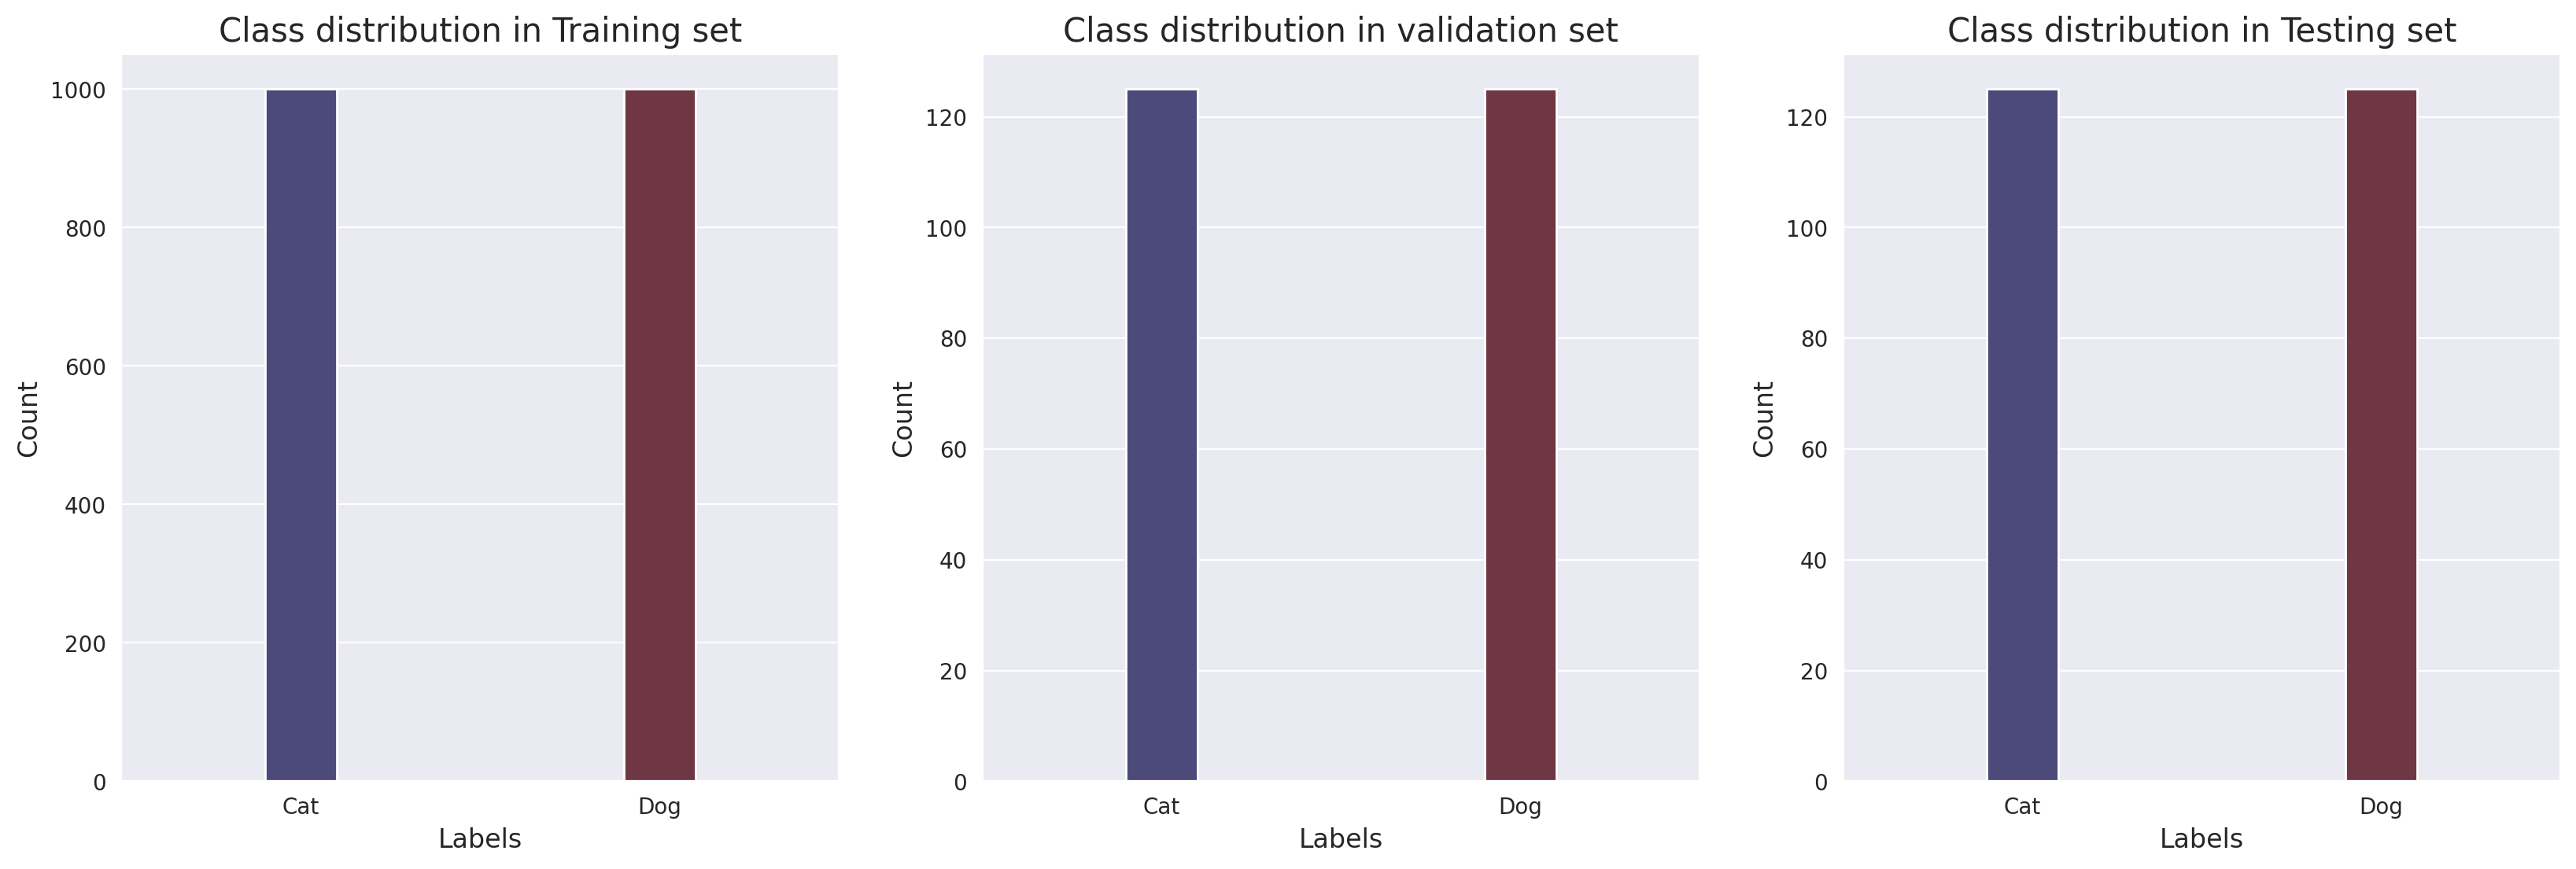

In [15]:
labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

### Data Preparation

In [16]:
# parameters
target_size = (456, 456)
batch_size = 16

### Image Data Generator

-  The data for will used by flow_from_dataframe.

- The batch size is 16 and the image size is (456, 456).

In [17]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'nearest',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = None,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = batch_size,
                                                    target_size = target_size,
                                                    class_mode='categorical',
                                                    color_mode= 'rgb'
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = None,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = batch_size,
                                                 target_size = target_size,
                                                 class_mode='categorical',
                                                 color_mode= 'rgb'
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = None,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = batch_size,
                                                  target_size = target_size,
                                                  class_mode='categorical',
                                                  color_mode= 'rgb'
                                                 )

Found 2000 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


In [19]:
#label
labels = (train_generator.class_indices)
print(labels)

{'Cat': 0, 'Dog': 1}


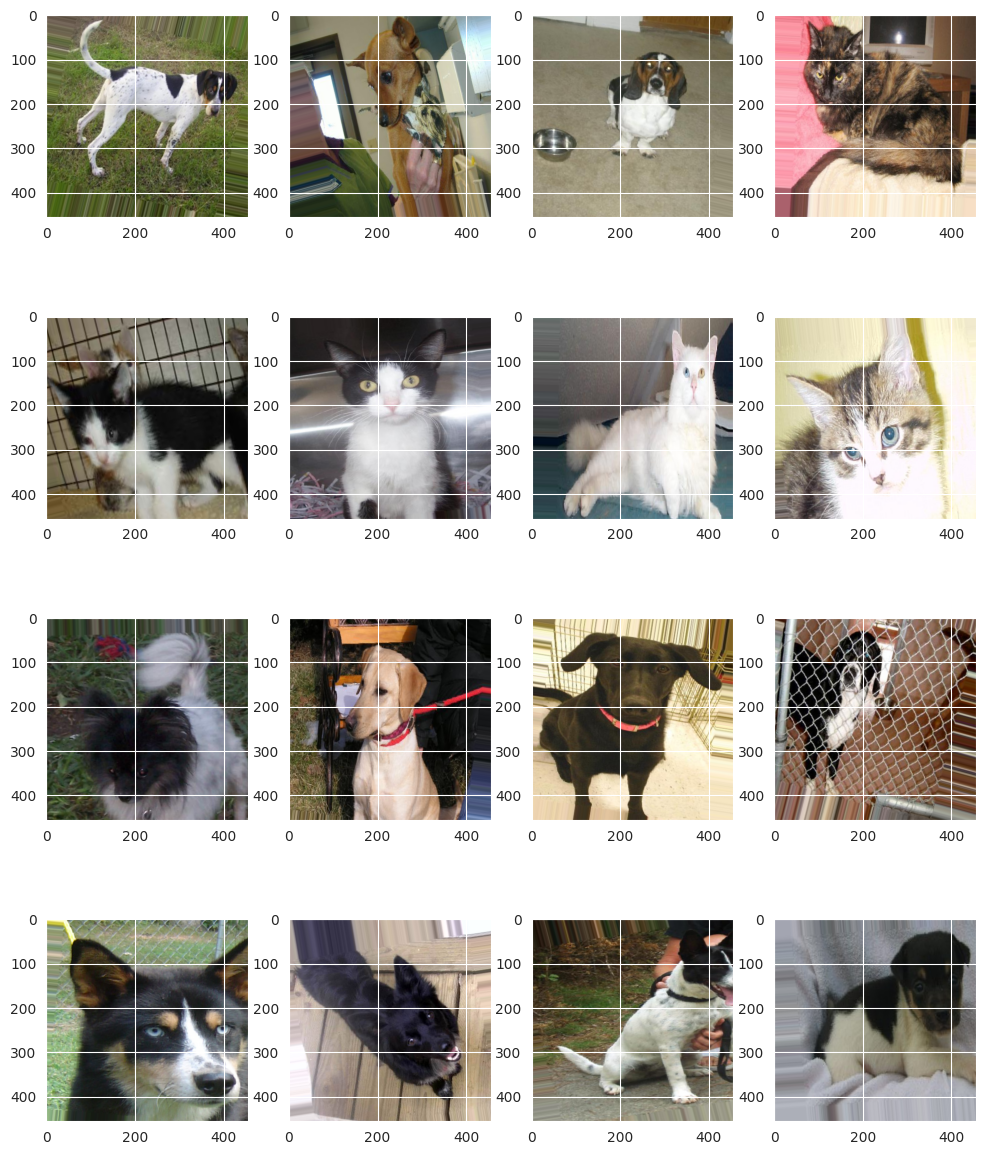

In [20]:
import cv2
import PIL
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(12, 15))
columns = 4
rows = 4
x, y = train_generator.next()
for i in range(0, columns*rows):
    image = x[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
plt.show()

## EfficienNet Model

In [21]:
# loading pretrained conv base model
from efficientnet.keras import EfficientNetB5 as Net

input_shape = (456, 456, 3)
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)
print(f"Input Shape: {input_shape}")

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation='softmax',name = 'predict_Cat_Dog')(dropout_layer)

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

115515256/115515256 [==============================] - 0s 0us/step
Input Shape: (456, 456, 3)


In [22]:
### Unfreeze FC layer
print('[INFO]: This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))
print('[INFO]: Freezing hidden layers...')
for layer in conv_base.layers:
    layer.trainable = False

print('[INFO]: This is the number of trainable layers '
        'after freezing the conv base:', len(model.trainable_weights))
print('-'*125)

[INFO]: This is the number of trainable layers before freezing the conv base: 506
[INFO]: Freezing hidden layers...
[INFO]: This is the number of trainable layers after freezing the conv base: 2
-----------------------------------------------------------------------------------------------------------------------------


In [23]:
model.summary()

Model: "EffNet_Cat_Dog"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 456, 456, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 228, 228, 48)         1296      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 228, 228, 48)         192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 228, 228, 48)         0         ['stem_bn[0][0]']

## Callbacks

- ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                              patience=2,
                                              factor=0.5,
                                              min_lr = 0.00001,
                                              verbose = 1)

## Compile the model

In [25]:
from keras.optimizers import Adam

lr=1e-4
#Training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=lr),
              metrics=['acc'])

## Fit the model

In [26]:
num_epochs = 20
history_eff = model.fit(train_generator,
                        epochs = num_epochs,
                        validation_data = val_generator,
                        callbacks=learning_rate_reduction)

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.4676 - acc: 0.8245

125/125 [==============================] - 152s 1s/step - loss: 0.4676 - acc: 0.8245 - val_loss: 0.2800 - val_acc: 0.9720 - lr: 1.0000e-04
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.2046 - acc: 0.9665

125/125 [==============================] - 125s 997ms/step - loss: 0.2046 - acc: 0.9665 - val_loss: 0.1444 - val_acc: 0.9800 - lr: 1.0000e-04
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.1180 - acc: 0.9845

125/125 [==============================] - 124s 991ms/step - loss: 0.1180 - acc: 0.9845 - val_loss: 0.0945 - val_acc: 0.9840 - lr: 1.0000e-04
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.0910 - acc: 0.9815

125/125 [==============================] - 124s 989ms/step - loss: 0.0910 - acc: 0.9815 - val_loss: 0.0704 - val_acc: 0.9840 - lr: 1.0000e-04
Epoch 5/20
125/125 [==============================] - ETA: 0s - loss: 0.0703 - acc: 0.9845

125/125 [==============================] - 124s 991ms/step - loss: 0.0703 - acc: 0.9845 - val_loss: 0.0561 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 6/20
125/125 [==============================] - ETA: 0s - loss: 0.0630 - acc: 0.9875

125/125 [==============================] - 124s 986ms/step - loss: 0.0630 - acc: 0.9875 - val_loss: 0.0489 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 7/20
125/125 [==============================] - ETA: 0s - loss: 0.0551 - acc: 0.9865

125/125 [==============================] - 124s 994ms/step - loss: 0.0551 - acc: 0.9865 - val_loss: 0.0422 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 8/20
125/125 [==============================] - ETA: 0s - loss: 0.0555 - acc: 0.9830

125/125 [==============================] - 124s 985ms/step - loss: 0.0555 - acc: 0.9830 - val_loss: 0.0387 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 9/20
125/125 [==============================] - ETA: 0s - loss: 0.0467 - acc: 0.9860

125/125 [==============================] - 124s 989ms/step - loss: 0.0467 - acc: 0.9860 - val_loss: 0.0361 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 10/20
125/125 [==============================] - ETA: 0s - loss: 0.0456 - acc: 0.9860

125/125 [==============================] - 128s 1s/step - loss: 0.0456 - acc: 0.9860 - val_loss: 0.0334 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 11/20
125/125 [==============================] - ETA: 0s - loss: 0.0441 - acc: 0.9895

125/125 [==============================] - 123s 983ms/step - loss: 0.0441 - acc: 0.9895 - val_loss: 0.0309 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.0381 - acc: 0.9890

125/125 [==============================] - 122s 978ms/step - loss: 0.0381 - acc: 0.9890 - val_loss: 0.0306 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 13/20
125/125 [==============================] - ETA: 0s - loss: 0.0400 - acc: 0.9890

125/125 [==============================] - 125s 998ms/step - loss: 0.0400 - acc: 0.9890 - val_loss: 0.0293 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 14/20
125/125 [==============================] - ETA: 0s - loss: 0.0381 - acc: 0.9880

125/125 [==============================] - 124s 992ms/step - loss: 0.0381 - acc: 0.9880 - val_loss: 0.0285 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 15/20
125/125 [==============================] - ETA: 0s - loss: 0.0366 - acc: 0.9880

125/125 [==============================] - 129s 1s/step - loss: 0.0366 - acc: 0.9880 - val_loss: 0.0268 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 16/20
125/125 [==============================] - ETA: 0s - loss: 0.0346 - acc: 0.9905

125/125 [==============================] - 124s 990ms/step - loss: 0.0346 - acc: 0.9905 - val_loss: 0.0262 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 17/20
125/125 [==============================] - ETA: 0s - loss: 0.0359 - acc: 0.9890

125/125 [==============================] - 124s 989ms/step - loss: 0.0359 - acc: 0.9890 - val_loss: 0.0262 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 18/20
125/125 [==============================] - ETA: 0s - loss: 0.0309 - acc: 0.9890

125/125 [==============================] - 124s 992ms/step - loss: 0.0309 - acc: 0.9890 - val_loss: 0.0256 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 19/20
125/125 [==============================] - ETA: 0s - loss: 0.0311 - acc: 0.9905

125/125 [==============================] - 123s 981ms/step - loss: 0.0311 - acc: 0.9905 - val_loss: 0.0251 - val_acc: 0.9920 - lr: 1.0000e-04
Epoch 20/20
125/125 [==============================] - ETA: 0s - loss: 0.0287 - acc: 0.9920

125/125 [==============================] - 125s 997ms/step - loss: 0.0287 - acc: 0.9920 - val_loss: 0.0245 - val_acc: 0.9920 - lr: 1.0000e-04


In [27]:
## Set up model path
#Categorical Crossentropy
modelName  = "EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
Model2save = f"/content/drive/MyDrive/{modelName}"
model.save(Model2save)
### print
print(f"[INFO]: Save Model as: {Model2save}")
print(f"*"*100)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]: Save Model as: /content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5
****************************************************************************************************


# Plot the results

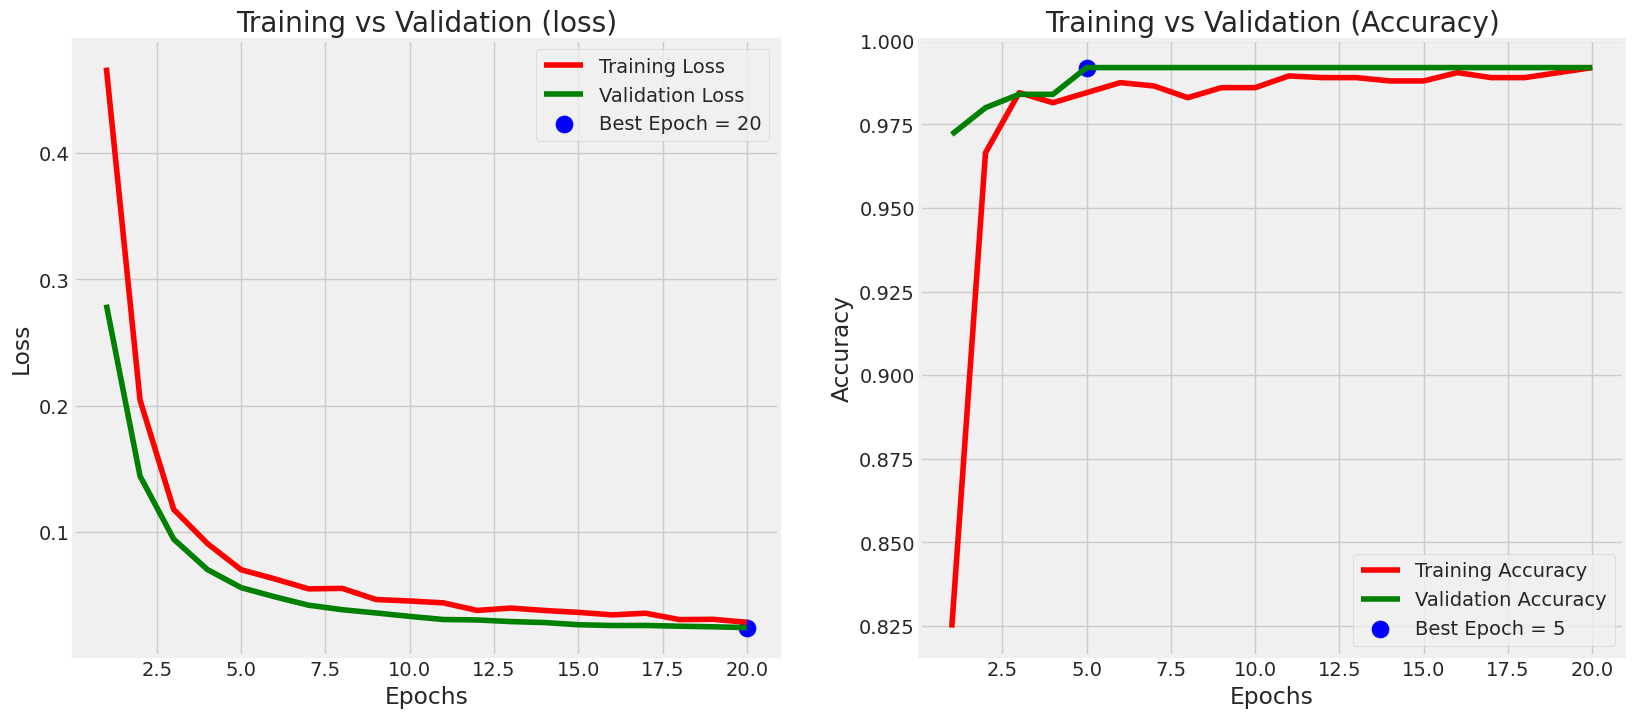

In [28]:
train_acc = history_eff.history['acc']
train_loss = history_eff.history['loss']

val_acc = history_eff.history['val_acc']
val_loss = history_eff.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

# Evaluation

In [29]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.50000047683716
The Loss of the model for training data is: 0.02112419530749321
The accuracy of the model for validation data is: 99.19999837875366
The Loss of the model for validation data is: 0.02452358417212963


# Prediction

In [30]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file

## Load model

In [31]:
model_dir = "/content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
model_B5 = load_model(model_dir)
height = width = model_B5.input_shape[1]
print(height, width)

456 456


In [32]:
model_B5.summary()

Model: "EffNet_Cat_Dog"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 456, 456, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 228, 228, 48)         1296      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 228, 228, 48)         192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 228, 228, 48)         0         ['stem_bn[0][0]']

In [33]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [34]:
def process_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.

    return x

In [35]:
def predict(img_path, model_B5):
    img_x = process_image(img_path)
    predict = model_B5.predict([img_x])
    predict0 = predict[0]
    result = np.argmax(predict0)
    pred_label = label_dict[result]
    pred_prob = predict0[result]

    print(f"[INFO]: Predict Classes ==> {pred_label} With Probability {pred_prob*100:.4f}%")

In [37]:
img_path1 = "/content/drive/MyDrive/_119932207_indifferentcatgettyimages.jpg"
predict(img_path1, model_B5)
image.load_img(img_path1, target_size=(height, width))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/_119932207_indifferentcatgettyimages.jpg'

1/1 [==============================] - 0s 136ms/step
[INFO]: Predict Classes ==> Dog With Probability 97.3297%


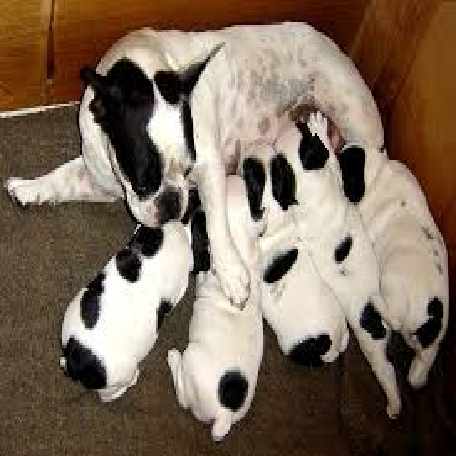

In [ ]:
img_path2 = "/content/drive/MyDrive/images.jpg"
predict(img_path2, model_B5)
image.load_img(img_path2, target_size=(height, width))

1/1 [==============================] - 0s 93ms/step
[INFO]: Predict Classes ==> Cat With Probability 99.9849%


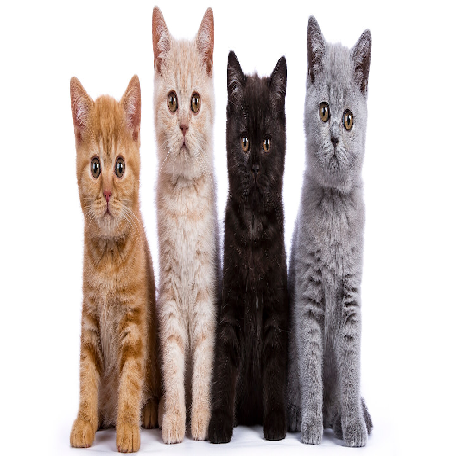

In [ ]:
img_path3 = "/content/drive/MyDrive/Hero Pedigree Cats.jpg"
predict(img_path3, model_B5)
image.load_img(img_path3, target_size=(height, width))

# Exercise

ทดลองนำภาพ นก รถยนต์ เสือ สิงโต และ สุนัขจิ้งจอก มาทำการทำนายและรายงานผลการทำนายแต่ละภาพ

In [38]:
img_path4 = "/content/drive/MyDrive/black-maned-lion-shem-compion-786x500.jpg"
predict(img_path4, model_B5)
image.load_img(img_path4, target_size=(height, width))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/black-maned-lion-shem-compion-786x500.jpg'

# Exercise

Print output ของ network

In [ ]:
network = "" # Need path. And somehow I couldn't find it
predict(network, model_B5)
image.load_img(img_path1, target_size=(height, width))

--------------------------------------------------------------------------------------

## Evaluating Model Performance

- Confusion matrix

In [ ]:
print(X_test.shape)
X_test.head()

(250, 2)


,filename,label
1095,/content/sample_data/PetImages/Cat/184.jpg,Cat
1179,/content/sample_data/PetImages/Cat/11194.jpg,Cat
925,/content/sample_data/PetImages/Dog/8486.jpg,Dog
1019,/content/sample_data/PetImages/Dog/5322.jpg,Dog
556,/content/sample_data/PetImages/Cat/9778.jpg,Cat


In [ ]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result[0]

In [ ]:
#Predict
pred_list = list()
prob_list = list()
img_path=X_test['filename'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(label_dict[result])
    prob_list.append(predict[result])

1/1 [==============================] - 0s 38ms/step


In [ ]:
predict

array([0.00679942, 0.9932006 ], dtype=float32)

In [ ]:
print(len(pred_list))
print(len(prob_list))

X_test['category'] = pred_list
X_test['Prob'] = prob_list
X_test.head()

250
250


,filename,label,category,Prob
1095,/content/sample_data/PetImages/Cat/184.jpg,Cat,Cat,0.999494
1179,/content/sample_data/PetImages/Cat/11194.jpg,Cat,Cat,0.812446
925,/content/sample_data/PetImages/Dog/8486.jpg,Dog,Dog,0.997590
1019,/content/sample_data/PetImages/Dog/5322.jpg,Dog,Dog,0.998882
556,/content/sample_data/PetImages/Cat/9778.jpg,Cat,Cat,0.999821


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = X_test['label'].array
pred = X_test['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 99.2%
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99       125
         Dog       0.99      0.99      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



## Confusion matrix

Text(0.5, 1.2499999999999805, 'Predicted label')

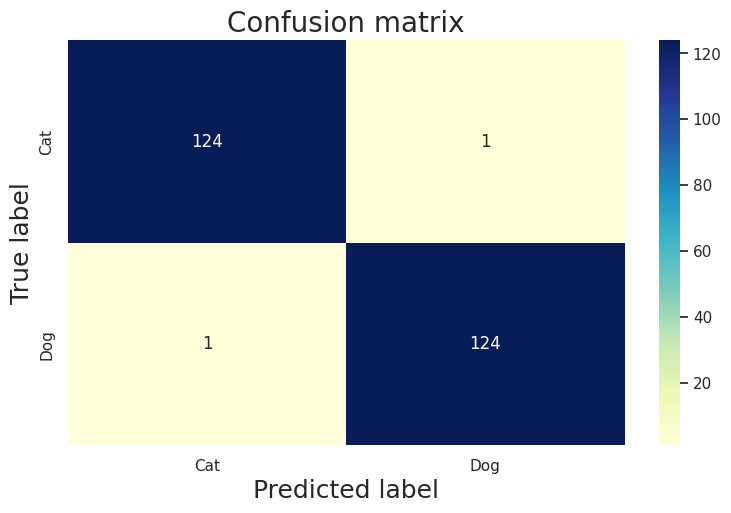

In [ ]:
#create CF
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

---------------------------------------

In [ ]:
img_path=X_test['filename'].tolist()
img_x  = predict_image(img_path[0])
img_x

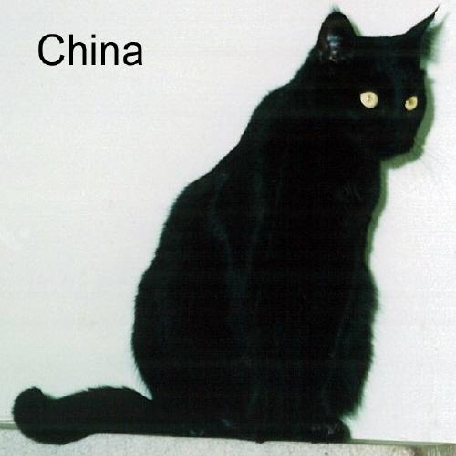

In [ ]:
image.load_img(img_path[0], target_size=(height, width))